# 準備

## Import 

In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision
import numpy as np
import gc  
from albumentations import (
    Compose, Normalize, Resize,
    RandomResizedCrop, HorizontalFlip,
    RandomBrightnessContrast, ShiftScaleRotate
)
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
import pytz
from tqdm import tqdm
import timm

In [3]:
class Config:
    patience=10
    num_epochs=80
    mixup_epochs=5
    batch_size=18
    model_type='resnet101'
    
config = Config()

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Use a chosen seed
set_seed(42)

In [5]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Get current date and time in JST
jst = pytz.timezone('Asia/Tokyo')
current_datetime = datetime.now(jst)
# Get current date and time
formatted_datetime = current_datetime.strftime('%Y%m%d%H%M%S')

print(formatted_datetime)

20230903212222


## Path

## def

In [7]:
def view_img(dir_name, file_name):
    
    info_table = pd.read_csv(f'../data/{dir_name}.csv', header=None, names=['name', 'label'])
    target_label = info_table[info_table['name']==f'{file_name}']['label']
    
    # # Display the image
    img = Image.open(f'../data/{dir_name}/'+file_name)
    # img = Image.open('../data/train_1/'+f'train_1811.png')
    
    plt.title(file_name)
    plt.imshow(img)
    plt.show()

    print("Label:", target_label.values[0])  # values[0] is used to get the first value if multiple rows match the condition
    print("Size of the image:", img.size)


# EDA

In [8]:
# df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
# df.head(3)

In [9]:
# random_idx = random.choice(range(len(df)))
# file_name = f'train_{random_idx}.png'
# dir_name = 'train_1'

# view_img(dir_name, file_name)

In [10]:
# # Directory to search
# directory = "../data/train_1/"

# # Maximum file size in bytes (40K in this case)
# max_size = 40 * 1024

# # Get list of files in the directory and subdirectories
# file_list = []

# for directory in ["../data/train_1/","../data/train_2/","../data/train_3/","../data/train_4/"]:
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             full_path = os.path.join(foldername, filename)
#             if os.path.getsize(full_path) <= max_size:
#                 file_list.append(full_path)

In [11]:
# file_list

In [12]:
# file_name = f'train_1474.png'
# dir_name = 'train_3'

# view_img(dir_name, file_name)

In [13]:
# # Get image paths for label 0 and 1
# image_paths_0 = df[df['label'] == 0]['name'].values
# image_paths_1 = df[df['label'] == 1]['name'].values

# # Function to display images
# def display_images(image_paths, title):
#     plt.figure(figsize=(10,10))
#     for i in range(9):  # display 9 images
#         plt.subplot(3,3,i+1)
#         img = Image.open(image_paths[i])
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

# # Display images for label 0 and 1
# display_images('../data/train_1/'+ image_paths_0, 'label_0')
# display_images('../data/train_1/'+ image_paths_1, 'label_1')

# ## 画像が欠損しているデータもあり

In [14]:
# df.groupby('label')['name'].count()

# ベースモデル

## 学習フェーズ

### 関数

In [15]:
def get_transforms():
    transforms_dict = {
        'train': Compose([
            RandomResizedCrop(512, 512),
            HorizontalFlip(),
            RandomBrightnessContrast(),
            ShiftScaleRotate(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        'valid': Compose([
            Resize(512, 512),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
    }
    return transforms_dict


def load_datasets(df, root_dir, transforms_dict):
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    datasets = {
        'train': CustomImageDataset(train_df, root_dir, transform=transforms_dict['train']),
        'valid': CustomImageDataset(valid_df, root_dir, transform=transforms_dict['valid'])
    }
    return datasets


def get_dataloaders(datasets, batch_size):
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False)
    }
    return dataloaders

    
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.df.iloc[idx, 1]
        if self.transform:
            transformed = self.transform(image=image)  # Apply the transformations
            image = transformed["image"]
        return image, label
    
def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            


    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
    
    
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
          

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
    # val_loss_minの値を取得
    def get_value(self):
        return self.val_loss_min
        
def train_model_mixup_el_stop(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, path=f'../models/{formatted_datetime}_{file_name}.pth',verbose=True)
    stop_training = False  # 早期停止フラグ
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid':
                early_stopping(-epoch_acc, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    stop_training = True
                    break

        if stop_training:
            break
 
    print('Finished Training') 
    
    return early_stopping.get_value()

### 実行

In [16]:
eval_dict=dict()

for ds in ['train_1','train_2','train_3','train_4']:
# for ds in ['train_4']:

    print(f'=== {ds}  学習中 ===')
    
    # Load labels from csv
    df = pd.read_csv(f'../data/{ds}.csv', header=None, names=['name', 'label'])
    
    # 40kB以下の空白画像をdfから削除
    file_list = []
    for foldername, subfolders, filenames in os.walk(os.path.join("../data/",ds)):
        for filename in filenames:
            full_path = os.path.join(foldername, filename)
            max_size = 40 * 1024
            if os.path.getsize(full_path) <= max_size:
                file_list.append(filename)
    df = df[~df['name'].isin(file_list)]
    
    # Get transforms
    transforms_dict = get_transforms()

    # Load datasets
    datasets = load_datasets(df, f'../data/{ds}/', transforms_dict)

    # Create dataloaders
    dataloaders = get_dataloaders(datasets, batch_size=config.batch_size)

    # Define model
    model = timm.create_model(config.model_type, pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2) 
#     model.classifier = nn.Linear(model.classifier.in_features, 2) 

    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
#     train_model(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds)
#     train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds, mixup_epochs=10)
    eval_dict[ds]= train_model_mixup_el_stop(
        dataloaders,
        model, 
        criterion,
        optimizer,
        num_epochs=config.num_epochs,
        file_name=ds, 
        mixup_epochs=config.mixup_epochs,
        patience=config.patience
    )

del df
del dataloaders
gc.collect()

=== train_1  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 220/220 [06:21<00:00,  1.73s/it]


train Loss: 0.6923 Acc: 0.5291


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.47it/s]


valid Loss: 0.6882 Acc: 0.6569
Validation loss decreased (inf --> -0.656912).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.6877 Acc: 0.6072


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.6834 Acc: 0.6781
Validation loss decreased (-0.656912 --> -0.678103).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 220/220 [06:16<00:00,  1.71s/it]


train Loss: 0.6849 Acc: 0.6148


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.6787 Acc: 0.6741
EarlyStopping counter: 1 out of 10
Epoch 4/80
----------


100%|█████████████████████████████████████████| 220/220 [06:10<00:00,  1.68s/it]


train Loss: 0.6803 Acc: 0.6292


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.6704 Acc: 0.6902
Validation loss decreased (-0.678103 --> -0.690212).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.6747 Acc: 0.6412


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.6662 Acc: 0.6872
EarlyStopping counter: 1 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 220/220 [06:18<00:00,  1.72s/it]


train Loss: 0.6657 Acc: 0.6497


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.53it/s]


valid Loss: 0.6566 Acc: 0.6579
EarlyStopping counter: 2 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 220/220 [06:06<00:00,  1.66s/it]


train Loss: 0.6557 Acc: 0.6687


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.52it/s]


valid Loss: 0.6428 Acc: 0.6731
EarlyStopping counter: 3 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.6460 Acc: 0.6644


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.6216 Acc: 0.6983
Validation loss decreased (-0.690212 --> -0.698285).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 220/220 [06:10<00:00,  1.68s/it]


train Loss: 0.6378 Acc: 0.6742


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.6124 Acc: 0.7064
Validation loss decreased (-0.698285 --> -0.706357).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.6225 Acc: 0.7040


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.5977 Acc: 0.7205
Validation loss decreased (-0.706357 --> -0.720484).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.6082 Acc: 0.6972


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.5795 Acc: 0.7154
EarlyStopping counter: 1 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.5947 Acc: 0.7124


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.5623 Acc: 0.7225
Validation loss decreased (-0.720484 --> -0.722503).  Saving model ...
Epoch 13/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.5762 Acc: 0.7227


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.5537 Acc: 0.7144
EarlyStopping counter: 1 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.5550 Acc: 0.7308


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.5375 Acc: 0.7336
Validation loss decreased (-0.722503 --> -0.733602).  Saving model ...
Epoch 15/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.5612 Acc: 0.7260


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.4822 Acc: 0.7911
Validation loss decreased (-0.733602 --> -0.791120).  Saving model ...
Epoch 16/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.5230 Acc: 0.7465


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.4875 Acc: 0.7780
EarlyStopping counter: 1 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.5240 Acc: 0.7523


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.5491 Acc: 0.7255
EarlyStopping counter: 2 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.5494 Acc: 0.7144


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.6094 Acc: 0.6640
EarlyStopping counter: 3 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 220/220 [06:18<00:00,  1.72s/it]


train Loss: 0.5883 Acc: 0.6838


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.5422 Acc: 0.7215
EarlyStopping counter: 4 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 220/220 [06:05<00:00,  1.66s/it]


train Loss: 0.5646 Acc: 0.7149


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.5811 Acc: 0.7043
EarlyStopping counter: 5 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 220/220 [06:08<00:00,  1.68s/it]


train Loss: 0.5362 Acc: 0.7336


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.5321 Acc: 0.7225
EarlyStopping counter: 6 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 220/220 [06:07<00:00,  1.67s/it]


train Loss: 0.5284 Acc: 0.7356


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.4956 Acc: 0.7558
EarlyStopping counter: 7 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.5093 Acc: 0.7495


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.5157 Acc: 0.7548
EarlyStopping counter: 8 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.4995 Acc: 0.7518


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.50it/s]


valid Loss: 0.4860 Acc: 0.7649
EarlyStopping counter: 9 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 220/220 [06:20<00:00,  1.73s/it]


train Loss: 0.5018 Acc: 0.7551


100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.51it/s]


valid Loss: 0.4511 Acc: 0.7770
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_2  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.6909 Acc: 0.5429


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.6869 Acc: 0.6357
Validation loss decreased (inf --> -0.635721).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.6866 Acc: 0.5923


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6806 Acc: 0.6831
Validation loss decreased (-0.635721 --> -0.683148).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.6818 Acc: 0.6326


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.6745 Acc: 0.7164
Validation loss decreased (-0.683148 --> -0.716448).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 220/220 [06:07<00:00,  1.67s/it]


train Loss: 0.6769 Acc: 0.6280


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.6686 Acc: 0.7144
EarlyStopping counter: 1 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 220/220 [06:13<00:00,  1.70s/it]


train Loss: 0.6722 Acc: 0.6460


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.6670 Acc: 0.6842
EarlyStopping counter: 2 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 220/220 [06:04<00:00,  1.66s/it]


train Loss: 0.6593 Acc: 0.6823


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.6626 Acc: 0.6539
EarlyStopping counter: 3 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 220/220 [06:03<00:00,  1.65s/it]


train Loss: 0.6484 Acc: 0.6836


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.6330 Acc: 0.7275
Validation loss decreased (-0.716448 --> -0.727548).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 220/220 [06:08<00:00,  1.68s/it]


train Loss: 0.6371 Acc: 0.6813


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6234 Acc: 0.7175
EarlyStopping counter: 1 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.6253 Acc: 0.6942


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.5930 Acc: 0.7679
Validation loss decreased (-0.727548 --> -0.767911).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 220/220 [06:03<00:00,  1.65s/it]


train Loss: 0.6134 Acc: 0.7063


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.5916 Acc: 0.7104
EarlyStopping counter: 1 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.5931 Acc: 0.7083


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5891 Acc: 0.7074
EarlyStopping counter: 2 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 220/220 [06:08<00:00,  1.67s/it]


train Loss: 0.5799 Acc: 0.7172


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.59it/s]


valid Loss: 0.5460 Acc: 0.7417
EarlyStopping counter: 3 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 220/220 [06:07<00:00,  1.67s/it]


train Loss: 0.4653 Acc: 0.7798


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.4013 Acc: 0.8244
Validation loss decreased (-0.798184 --> -0.824420).  Saving model ...
Epoch 21/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.70s/it]


train Loss: 0.4571 Acc: 0.7912


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.3800 Acc: 0.8355
Validation loss decreased (-0.824420 --> -0.835520).  Saving model ...
Epoch 22/80
----------


100%|█████████████████████████████████████████| 220/220 [06:13<00:00,  1.70s/it]


train Loss: 0.4379 Acc: 0.7967


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3542 Acc: 0.8406
Validation loss decreased (-0.835520 --> -0.840565).  Saving model ...
Epoch 23/80
----------


100%|█████████████████████████████████████████| 220/220 [06:08<00:00,  1.67s/it]


train Loss: 0.4214 Acc: 0.8109


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.3487 Acc: 0.8396
EarlyStopping counter: 1 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.4306 Acc: 0.8066


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.4933 Acc: 0.7780
EarlyStopping counter: 2 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 220/220 [06:09<00:00,  1.68s/it]


train Loss: 0.4127 Acc: 0.8088


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3789 Acc: 0.8194
EarlyStopping counter: 3 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 220/220 [06:11<00:00,  1.69s/it]


train Loss: 0.4070 Acc: 0.8109


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.4202 Acc: 0.8093
EarlyStopping counter: 4 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 220/220 [06:02<00:00,  1.65s/it]


train Loss: 0.3884 Acc: 0.8230


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.3360 Acc: 0.8406
Validation loss decreased (-0.840565 --> -0.840565).  Saving model ...
Epoch 28/80
----------


100%|█████████████████████████████████████████| 220/220 [06:15<00:00,  1.71s/it]


train Loss: 0.4104 Acc: 0.8088


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3952 Acc: 0.8163
EarlyStopping counter: 1 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.3774 Acc: 0.8278


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3274 Acc: 0.8486
Validation loss decreased (-0.840565 --> -0.848638).  Saving model ...
Epoch 30/80
----------


100%|█████████████████████████████████████████| 220/220 [06:08<00:00,  1.68s/it]


train Loss: 0.3725 Acc: 0.8371


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.3225 Acc: 0.8698
Validation loss decreased (-0.848638 --> -0.869828).  Saving model ...
Epoch 31/80
----------


100%|█████████████████████████████████████████| 220/220 [06:13<00:00,  1.70s/it]


train Loss: 0.3741 Acc: 0.8369


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.3052 Acc: 0.8749
Validation loss decreased (-0.869828 --> -0.874874).  Saving model ...
Epoch 32/80
----------


100%|█████████████████████████████████████████| 220/220 [06:07<00:00,  1.67s/it]


train Loss: 0.3800 Acc: 0.8290


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.2824 Acc: 0.8860
Validation loss decreased (-0.874874 --> -0.885974).  Saving model ...
Epoch 33/80
----------


100%|█████████████████████████████████████████| 220/220 [06:07<00:00,  1.67s/it]


train Loss: 0.3701 Acc: 0.8361


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.59it/s]


valid Loss: 0.2621 Acc: 0.9011
Validation loss decreased (-0.885974 --> -0.901110).  Saving model ...
Epoch 34/80
----------


100%|█████████████████████████████████████████| 220/220 [06:06<00:00,  1.67s/it]


train Loss: 0.3667 Acc: 0.8321


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.58it/s]


valid Loss: 0.3278 Acc: 0.8507
EarlyStopping counter: 1 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 220/220 [06:09<00:00,  1.68s/it]


train Loss: 0.3410 Acc: 0.8490


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.3023 Acc: 0.8547
EarlyStopping counter: 2 out of 10
Epoch 36/80
----------


100%|█████████████████████████████████████████| 220/220 [06:05<00:00,  1.66s/it]


train Loss: 0.3547 Acc: 0.8465


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3226 Acc: 0.8658
EarlyStopping counter: 3 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 220/220 [06:06<00:00,  1.66s/it]


train Loss: 0.3566 Acc: 0.8386


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2989 Acc: 0.8648
EarlyStopping counter: 4 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.3393 Acc: 0.8535


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2452 Acc: 0.9011
Validation loss decreased (-0.901110 --> -0.901110).  Saving model ...
Epoch 39/80
----------


100%|█████████████████████████████████████████| 220/220 [06:13<00:00,  1.70s/it]


train Loss: 0.3378 Acc: 0.8576


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3224 Acc: 0.8476
EarlyStopping counter: 1 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.3410 Acc: 0.8510


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4146 Acc: 0.8295
EarlyStopping counter: 2 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 220/220 [06:06<00:00,  1.67s/it]


train Loss: 0.2983 Acc: 0.8742


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.2555 Acc: 0.9031
EarlyStopping counter: 2 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 220/220 [06:06<00:00,  1.67s/it]


train Loss: 0.2887 Acc: 0.8778


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4168 Acc: 0.8345
EarlyStopping counter: 3 out of 10
Epoch 50/80
----------


100%|█████████████████████████████████████████| 220/220 [06:02<00:00,  1.65s/it]


train Loss: 0.3087 Acc: 0.8649


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.2226 Acc: 0.9173
Validation loss decreased (-0.907164 --> -0.917255).  Saving model ...
Epoch 51/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.2981 Acc: 0.8763


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2394 Acc: 0.9021
EarlyStopping counter: 1 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 220/220 [06:10<00:00,  1.68s/it]


train Loss: 0.3012 Acc: 0.8682


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.2259 Acc: 0.9142
EarlyStopping counter: 2 out of 10
Epoch 53/80
----------


100%|█████████████████████████████████████████| 220/220 [06:03<00:00,  1.65s/it]


train Loss: 0.2942 Acc: 0.8783


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.7938 Acc: 0.6831
EarlyStopping counter: 3 out of 10
Epoch 54/80
----------


100%|█████████████████████████████████████████| 220/220 [06:01<00:00,  1.64s/it]


train Loss: 0.2797 Acc: 0.8818


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.2394 Acc: 0.9062
EarlyStopping counter: 4 out of 10
Epoch 55/80
----------


100%|█████████████████████████████████████████| 220/220 [06:07<00:00,  1.67s/it]


train Loss: 0.2876 Acc: 0.8765


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2198 Acc: 0.9173
Validation loss decreased (-0.917255 --> -0.917255).  Saving model ...
Epoch 56/80
----------


100%|█████████████████████████████████████████| 220/220 [06:10<00:00,  1.68s/it]


train Loss: 0.2887 Acc: 0.8831


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.2062 Acc: 0.9193
Validation loss decreased (-0.917255 --> -0.919273).  Saving model ...
Epoch 57/80
----------


100%|█████████████████████████████████████████| 220/220 [06:10<00:00,  1.68s/it]


train Loss: 0.2556 Acc: 0.8919


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.1958 Acc: 0.9284
Validation loss decreased (-0.919273 --> -0.928355).  Saving model ...
Epoch 58/80
----------


100%|█████████████████████████████████████████| 220/220 [06:01<00:00,  1.64s/it]


train Loss: 0.2632 Acc: 0.8836


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.1887 Acc: 0.9314
Validation loss decreased (-0.928355 --> -0.931382).  Saving model ...
Epoch 59/80
----------


 42%|█████████████████▊                        | 93/220 [02:32<03:27,  1.63s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 220/220 [06:09<00:00,  1.68s/it]


train Loss: 0.2660 Acc: 0.8886


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.1796 Acc: 0.9324
EarlyStopping counter: 2 out of 10
Epoch 63/80
----------


100%|█████████████████████████████████████████| 220/220 [06:05<00:00,  1.66s/it]


train Loss: 0.2523 Acc: 0.8909


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.1995 Acc: 0.9203
EarlyStopping counter: 3 out of 10
Epoch 64/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.2636 Acc: 0.8932


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2119 Acc: 0.9132
EarlyStopping counter: 4 out of 10
Epoch 65/80
----------


100%|█████████████████████████████████████████| 220/220 [06:14<00:00,  1.70s/it]


train Loss: 0.2764 Acc: 0.8831


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.2788 Acc: 0.8840
EarlyStopping counter: 5 out of 10
Epoch 66/80
----------


100%|█████████████████████████████████████████| 220/220 [06:08<00:00,  1.67s/it]


train Loss: 0.2593 Acc: 0.8899


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.1710 Acc: 0.9294
EarlyStopping counter: 6 out of 10
Epoch 67/80
----------


100%|█████████████████████████████████████████| 220/220 [06:12<00:00,  1.69s/it]


train Loss: 0.2652 Acc: 0.8891


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.2026 Acc: 0.9183
EarlyStopping counter: 7 out of 10
Epoch 68/80
----------


100%|█████████████████████████████████████████| 220/220 [06:13<00:00,  1.70s/it]


train Loss: 0.2437 Acc: 0.8955


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.58it/s]


valid Loss: 0.1706 Acc: 0.9294
EarlyStopping counter: 8 out of 10
Epoch 69/80
----------


100%|█████████████████████████████████████████| 220/220 [06:00<00:00,  1.64s/it]


train Loss: 0.2580 Acc: 0.8955


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.2017 Acc: 0.9112
EarlyStopping counter: 9 out of 10
Epoch 70/80
----------


100%|█████████████████████████████████████████| 220/220 [06:09<00:00,  1.68s/it]


train Loss: 0.2588 Acc: 0.8924


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2265 Acc: 0.9102
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_3  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 221/221 [06:19<00:00,  1.72s/it]


train Loss: 0.6912 Acc: 0.5454


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.52it/s]


valid Loss: 0.6869 Acc: 0.6576
Validation loss decreased (inf --> -0.657603).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 221/221 [06:13<00:00,  1.69s/it]


train Loss: 0.6873 Acc: 0.6087


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.6789 Acc: 0.6818
Validation loss decreased (-0.657603 --> -0.681772).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 221/221 [06:12<00:00,  1.68s/it]


train Loss: 0.6834 Acc: 0.6243


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6729 Acc: 0.7059
Validation loss decreased (-0.681772 --> -0.705942).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.6782 Acc: 0.6357


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6687 Acc: 0.6717
EarlyStopping counter: 1 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.6747 Acc: 0.6294


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6600 Acc: 0.6898
EarlyStopping counter: 2 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.6615 Acc: 0.6682


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.6485 Acc: 0.7281
Validation loss decreased (-0.705942 --> -0.728097).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 221/221 [06:07<00:00,  1.66s/it]


train Loss: 0.6512 Acc: 0.6845


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6294 Acc: 0.7452
Validation loss decreased (-0.728097 --> -0.745217).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.6431 Acc: 0.6747


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6257 Acc: 0.7029
EarlyStopping counter: 1 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 221/221 [06:07<00:00,  1.66s/it]


train Loss: 0.6352 Acc: 0.6881


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.6102 Acc: 0.7190
EarlyStopping counter: 2 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 221/221 [06:04<00:00,  1.65s/it]


train Loss: 0.6253 Acc: 0.6888


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.6021 Acc: 0.7090
EarlyStopping counter: 3 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 221/221 [06:12<00:00,  1.69s/it]


train Loss: 0.6047 Acc: 0.7085


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5890 Acc: 0.7029
EarlyStopping counter: 4 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 221/221 [06:10<00:00,  1.68s/it]


train Loss: 0.5969 Acc: 0.7039


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.59it/s]


valid Loss: 0.5427 Acc: 0.7442
EarlyStopping counter: 5 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 221/221 [06:06<00:00,  1.66s/it]


train Loss: 0.5744 Acc: 0.7223


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.5606 Acc: 0.7200
EarlyStopping counter: 6 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 221/221 [06:07<00:00,  1.66s/it]


train Loss: 0.5612 Acc: 0.7251


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.58it/s]


valid Loss: 0.5351 Acc: 0.7392
EarlyStopping counter: 7 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.5424 Acc: 0.7331


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4910 Acc: 0.7613
Validation loss decreased (-0.745217 --> -0.761329).  Saving model ...
Epoch 16/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.5441 Acc: 0.7314


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.4920 Acc: 0.7734
Validation loss decreased (-0.761329 --> -0.773414).  Saving model ...
Epoch 17/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.5345 Acc: 0.7379


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4586 Acc: 0.7865
Validation loss decreased (-0.773414 --> -0.786506).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 221/221 [06:14<00:00,  1.70s/it]


train Loss: 0.5189 Acc: 0.7447


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4960 Acc: 0.7603
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.4985 Acc: 0.7606


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4281 Acc: 0.8127
Validation loss decreased (-0.786506 --> -0.812689).  Saving model ...
Epoch 20/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.4998 Acc: 0.7623


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4361 Acc: 0.8117
EarlyStopping counter: 1 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 221/221 [06:14<00:00,  1.70s/it]


train Loss: 0.4748 Acc: 0.7744


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4031 Acc: 0.8157
Validation loss decreased (-0.812689 --> -0.815710).  Saving model ...
Epoch 22/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.4706 Acc: 0.7724


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4009 Acc: 0.8348
Validation loss decreased (-0.815710 --> -0.834844).  Saving model ...
Epoch 23/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.4567 Acc: 0.7807


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.4555 Acc: 0.7996
EarlyStopping counter: 1 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 221/221 [06:10<00:00,  1.68s/it]


train Loss: 0.4568 Acc: 0.7918


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.4277 Acc: 0.8087
EarlyStopping counter: 2 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 221/221 [06:13<00:00,  1.69s/it]


train Loss: 0.4457 Acc: 0.7883


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3958 Acc: 0.8288
EarlyStopping counter: 3 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 221/221 [06:08<00:00,  1.67s/it]


train Loss: 0.4504 Acc: 0.7893


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.4701 Acc: 0.8066
EarlyStopping counter: 4 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.4317 Acc: 0.8011


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.3474 Acc: 0.8550
Validation loss decreased (-0.834844 --> -0.854985).  Saving model ...
Epoch 28/80
----------


100%|█████████████████████████████████████████| 221/221 [06:07<00:00,  1.66s/it]


train Loss: 0.4119 Acc: 0.8150


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3511 Acc: 0.8510
EarlyStopping counter: 1 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.4132 Acc: 0.8079


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3279 Acc: 0.8590
Validation loss decreased (-0.854985 --> -0.859013).  Saving model ...
Epoch 30/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.4290 Acc: 0.8036


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.4195 Acc: 0.8066
EarlyStopping counter: 1 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 221/221 [06:10<00:00,  1.68s/it]


train Loss: 0.4019 Acc: 0.8212


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.3682 Acc: 0.8671
Validation loss decreased (-0.859013 --> -0.867069).  Saving model ...
Epoch 32/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.4101 Acc: 0.8102


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.3435 Acc: 0.8499
EarlyStopping counter: 1 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 221/221 [06:04<00:00,  1.65s/it]


train Loss: 0.3944 Acc: 0.8212


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3210 Acc: 0.8580
EarlyStopping counter: 2 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.3820 Acc: 0.8301


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3782 Acc: 0.8348
EarlyStopping counter: 3 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.3898 Acc: 0.8205


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3542 Acc: 0.8459
EarlyStopping counter: 4 out of 10
Epoch 36/80
----------


100%|█████████████████████████████████████████| 221/221 [06:14<00:00,  1.70s/it]


train Loss: 0.3807 Acc: 0.8278


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3620 Acc: 0.8409
EarlyStopping counter: 5 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 221/221 [06:06<00:00,  1.66s/it]


train Loss: 0.3837 Acc: 0.8245


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.2589 Acc: 0.9033
Validation loss decreased (-0.867069 --> -0.903323).  Saving model ...
Epoch 38/80
----------


100%|█████████████████████████████████████████| 221/221 [06:08<00:00,  1.67s/it]


train Loss: 0.3642 Acc: 0.8374


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2966 Acc: 0.8741
EarlyStopping counter: 1 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 221/221 [06:14<00:00,  1.69s/it]


train Loss: 0.3693 Acc: 0.8374


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.55it/s]


valid Loss: 0.2697 Acc: 0.8912
EarlyStopping counter: 2 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.3446 Acc: 0.8454


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.58it/s]


valid Loss: 0.2478 Acc: 0.8993
EarlyStopping counter: 3 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.3517 Acc: 0.8462


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2792 Acc: 0.8832
EarlyStopping counter: 4 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3383 Acc: 0.8527


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2670 Acc: 0.8912
EarlyStopping counter: 5 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3467 Acc: 0.8444


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2544 Acc: 0.8933
EarlyStopping counter: 6 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3521 Acc: 0.8421


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2645 Acc: 0.8862
EarlyStopping counter: 7 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3506 Acc: 0.8447


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2107 Acc: 0.9235
Validation loss decreased (-0.903323 --> -0.923464).  Saving model ...
Epoch 46/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3422 Acc: 0.8527


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3335 Acc: 0.8570
EarlyStopping counter: 1 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3420 Acc: 0.8477


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.3261 Acc: 0.8741
EarlyStopping counter: 2 out of 10
Epoch 48/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3411 Acc: 0.8552


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2791 Acc: 0.8892
EarlyStopping counter: 3 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3311 Acc: 0.8565


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2220 Acc: 0.9144
EarlyStopping counter: 4 out of 10
Epoch 50/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3367 Acc: 0.8532


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2327 Acc: 0.9104
EarlyStopping counter: 5 out of 10
Epoch 51/80
----------


100%|█████████████████████████████████████████| 221/221 [06:08<00:00,  1.67s/it]


train Loss: 0.3308 Acc: 0.8570


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2692 Acc: 0.8973
EarlyStopping counter: 6 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.3238 Acc: 0.8646


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.3135 Acc: 0.8580
EarlyStopping counter: 7 out of 10
Epoch 53/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.3208 Acc: 0.8618


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2968 Acc: 0.8751
EarlyStopping counter: 8 out of 10
Epoch 54/80
----------


100%|█████████████████████████████████████████| 221/221 [06:16<00:00,  1.70s/it]


train Loss: 0.3098 Acc: 0.8648


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2478 Acc: 0.8973
EarlyStopping counter: 9 out of 10
Epoch 55/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.3015 Acc: 0.8724


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.2329 Acc: 0.8983
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_4  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 221/221 [06:12<00:00,  1.68s/it]


train Loss: 0.6916 Acc: 0.5416


100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.52it/s]


valid Loss: 0.6888 Acc: 0.6034
Validation loss decreased (inf --> -0.603431).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.6870 Acc: 0.5995


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.6824 Acc: 0.6700
Validation loss decreased (-0.603431 --> -0.670030).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 221/221 [06:14<00:00,  1.70s/it]


train Loss: 0.6827 Acc: 0.6136


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.6774 Acc: 0.6791
Validation loss decreased (-0.670030 --> -0.679112).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 221/221 [06:14<00:00,  1.69s/it]


train Loss: 0.6769 Acc: 0.6315


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.6720 Acc: 0.6680
EarlyStopping counter: 1 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 221/221 [06:07<00:00,  1.66s/it]


train Loss: 0.6733 Acc: 0.6347


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.59it/s]


valid Loss: 0.6589 Acc: 0.6801
Validation loss decreased (-0.679112 --> -0.680121).  Saving model ...
Epoch 6/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.6599 Acc: 0.6583


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.60it/s]


valid Loss: 0.6516 Acc: 0.6710
EarlyStopping counter: 1 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.6497 Acc: 0.6630


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.58it/s]


valid Loss: 0.6521 Acc: 0.6781
EarlyStopping counter: 2 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 221/221 [06:08<00:00,  1.67s/it]


train Loss: 0.6410 Acc: 0.6666


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.6389 Acc: 0.6710
EarlyStopping counter: 3 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 221/221 [06:04<00:00,  1.65s/it]


train Loss: 0.6316 Acc: 0.6673


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.6328 Acc: 0.6761
EarlyStopping counter: 4 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 221/221 [06:06<00:00,  1.66s/it]


train Loss: 0.6177 Acc: 0.6845


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.59it/s]


valid Loss: 0.6214 Acc: 0.6922
Validation loss decreased (-0.680121 --> -0.692230).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 221/221 [06:03<00:00,  1.64s/it]


train Loss: 0.6049 Acc: 0.6984


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.5895 Acc: 0.7053
Validation loss decreased (-0.692230 --> -0.705348).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 221/221 [06:04<00:00,  1.65s/it]


train Loss: 0.5900 Acc: 0.6979


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.5887 Acc: 0.6801
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 221/221 [06:03<00:00,  1.64s/it]


train Loss: 0.5710 Acc: 0.7181


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.6095 Acc: 0.7195
Validation loss decreased (-0.705348 --> -0.719475).  Saving model ...
Epoch 14/80
----------


100%|█████████████████████████████████████████| 221/221 [06:03<00:00,  1.64s/it]


train Loss: 0.5702 Acc: 0.7118


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.5854 Acc: 0.7074
EarlyStopping counter: 1 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 221/221 [06:13<00:00,  1.69s/it]


train Loss: 0.5629 Acc: 0.7198


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.5521 Acc: 0.7033
EarlyStopping counter: 2 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 221/221 [06:13<00:00,  1.69s/it]


train Loss: 0.5397 Acc: 0.7327


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5366 Acc: 0.7760
Validation loss decreased (-0.719475 --> -0.775984).  Saving model ...
Epoch 17/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.5286 Acc: 0.7446


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5276 Acc: 0.7497
EarlyStopping counter: 1 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.5225 Acc: 0.7451


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.7216 Acc: 0.4894
EarlyStopping counter: 2 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.6423 Acc: 0.6310


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.6427 Acc: 0.6165
EarlyStopping counter: 3 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 221/221 [06:07<00:00,  1.66s/it]


train Loss: 0.5910 Acc: 0.6964


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.59it/s]


valid Loss: 0.5982 Acc: 0.6549
EarlyStopping counter: 4 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.5728 Acc: 0.7047


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.61it/s]


valid Loss: 0.5757 Acc: 0.6700
EarlyStopping counter: 5 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 221/221 [06:11<00:00,  1.68s/it]


train Loss: 0.5723 Acc: 0.7153


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5539 Acc: 0.7134
EarlyStopping counter: 6 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 221/221 [06:06<00:00,  1.66s/it]


train Loss: 0.5554 Acc: 0.7181


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.57it/s]


valid Loss: 0.5449 Acc: 0.7154
EarlyStopping counter: 7 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 221/221 [06:15<00:00,  1.70s/it]


train Loss: 0.5493 Acc: 0.7246


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5412 Acc: 0.7074
EarlyStopping counter: 8 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 221/221 [06:09<00:00,  1.67s/it]


train Loss: 0.5460 Acc: 0.7196


100%|███████████████████████████████████████████| 56/56 [00:34<00:00,  1.60it/s]


valid Loss: 0.5061 Acc: 0.7538
EarlyStopping counter: 9 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 221/221 [06:13<00:00,  1.69s/it]


train Loss: 0.5384 Acc: 0.7309


100%|███████████████████████████████████████████| 56/56 [00:35<00:00,  1.56it/s]


valid Loss: 0.5557 Acc: 0.7033
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training


0

In [17]:
print(eval_dict)

{'train_1': -0.7911200807265388, 'train_2': -0.9434914228052472, 'train_3': -0.9234642497482377, 'train_4': -0.7759838546922301}


In [18]:
acc_ave = sum(eval_dict.values()) / len(eval_dict)
acc_ave = abs(acc_ave)
acc_ave = round(acc_ave, 4)
acc_ave = str(acc_ave)
acc_ave = acc_ave.replace('.', '_')

print(acc_ave)

0_8585


## 予測フェーズ

### 関数

In [19]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, self.image_files[idx] 

### 実行

In [20]:
transforms_dict = get_transforms()

test_data = TestDataset(root_dir='../data/evaluation/', transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# モデルのパスをリストにします
model_paths = [
    f'../models/{formatted_datetime}_train_1.pth',
    f'../models/{formatted_datetime}_train_2.pth',
    f'../models/{formatted_datetime}_train_3.pth',
    f'../models/{formatted_datetime}_train_4.pth',
] 

# 空のリストを作成して各モデルの予測を格納します
all_predictions = []

for model_path in model_paths:
    print('■実行中:', model_path)
    
    # モデルのインスタンスを作成します
    model = timm.create_model(config.model_type, pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2) 
#     model.classifier = nn.Linear(model.classifier.in_features, 2) 

    # 状態辞書をロードします
    model.load_state_dict(torch.load(model_path))

    # モデルをGPUに移動します
    model = model.to(device)

    # モデルを評価モードに設定します
    model.eval()

    # このモデルの予測を格納するリストを作成します
    model_predictions = []

    # データローダーからバッチを取得して予測を行います
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, _ = data
            images = images.to(device)
            
            logits = model(images)
            probabilities = F.softmax(logits, dim=1)  # apply softmax to convert logits to probabilities
            model_predictions.extend(probabilities.tolist())  # convert PyTorch tensor to Python list

    # すべてのモデルの予測を格納するリストにこのモデルの予測を追加します
    all_predictions.append(model_predictions)

# 全モデルの予測を平均します
final_predictions = np.mean(all_predictions, axis=0)

■実行中: ../models/20230903212222_train_1.pth


100%|█████████████████████████████████████████| 469/469 [08:39<00:00,  1.11s/it]


■実行中: ../models/20230903212222_train_2.pth


100%|█████████████████████████████████████████| 469/469 [08:23<00:00,  1.07s/it]


■実行中: ../models/20230903212222_train_3.pth


100%|█████████████████████████████████████████| 469/469 [08:17<00:00,  1.06s/it]


■実行中: ../models/20230903212222_train_4.pth


100%|█████████████████████████████████████████| 469/469 [08:20<00:00,  1.07s/it]


In [21]:
# submit用に整形
# Create a DataFrame with the image names and the probabilities
df_submission = pd.DataFrame({
    'image_name': [f'test_{i}.png' for i in range(len(final_predictions))],
    'probability': [probs[1] for probs in final_predictions]
})

# Write the DataFrame to a csv file
df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}_acc{acc_ave}.csv', index=False,header=False)
# df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}.csv', index=False,header=False)

<Axes: >

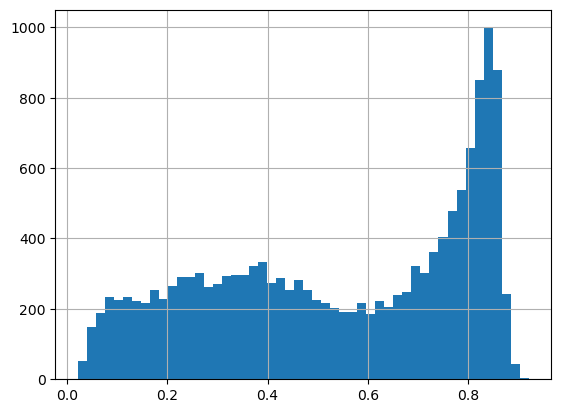

In [22]:
df_submission.probability.hist(bins=50)

In [23]:
df_submission.probability.min()

0.02117925563834433

In [24]:
df_submission.probability.max()

0.9212997853755951